### Задание 2
Настройте и обучите модель Mnist_CNN модели (см. Лекцию 2, файл Torchnn.ipynb) на данных из набора DTD. Объедините валидационный набор с обучающим и проведите обучение с кросс-валидацией. Выведите произвольные изображения разных классов, модель и кривые истории обучения в Tensorboard. Сделайте вывод об обучении модели. (40 баллов)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Фикс URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] (опционально)
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Загрузка датасета DTD в .data/*
training_data = datasets.DTD(
    root="data",
    download=True,
    split='train',
    transform=transforms.ToTensor()
)

test_data = datasets.DTD(
    root="data",
    download=True,
    split='test',
    transform=transforms.ToTensor()
)

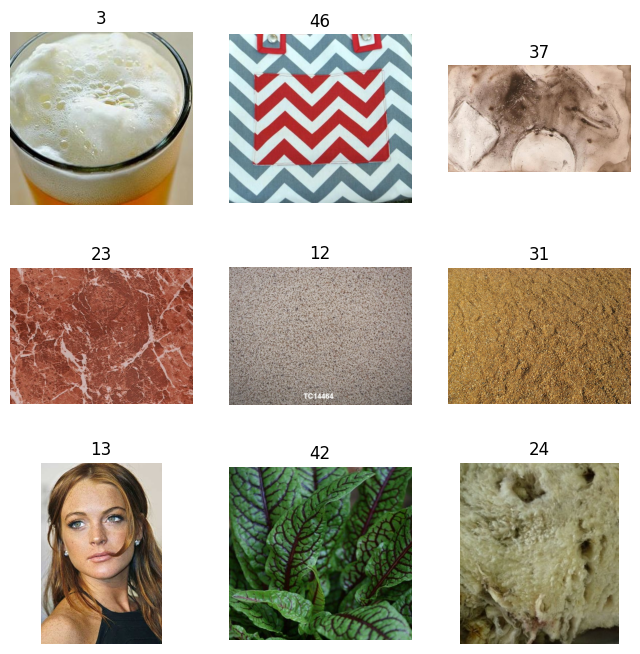

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
plt.show()

In [5]:
# Путь к папке с данными DTD
data_path = 'data/dtd/dtd/images/'

# Преобразования для изображений
transform_train = transforms.Compose([
    transforms.RandomCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [6]:
# Загрузка данных для обучения
train_ds = torchvision.datasets.ImageFolder(data_path, transform_train)

# Объединение обучающего и валидационных наборов
train_ds, valid_ds = torch.utils.data.random_split(train_ds, [len(train_ds)-100, 100])

# Загрузка данных для тестирования
test_ds = torchvision.datasets.ImageFolder(data_path, transform_test)

# Создание итераторов для обучения, валидации и тестирования
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [19]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(600*600, 60)
        self.fc2 = nn.Linear(60, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Mnist_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct.double() / len(train_loader.dataset)
    
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    for i, (inputs, labels) in enumerate(valid_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            valid_correct += torch.sum(preds == labels.data)
            
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_acc = valid_correct.double() / len(valid_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (12288x128 and 360000x60)